# Project: A/B Test a New Menu Launch (Part2)

### by Sooyeon Won

### Keywords
- Analytical Framework
- Data Exploration 
- Control Variables  Selection for A/B test Design
- Data Visualization

## Table of Contents
<ul>
<li><a href="#Intro">Introduction (Part1)</a></li>
<li><a href="#Wrangling">Data Wrangling (Part1)</a></li>
<li><a href="#Exploration">Data Exploration (Part2)</a></li>
<li><a href="#Analysis">Data Analysis (Part3)</a></li>
<li><a href="#Conclusion">Conclusion (Part3)</a></li>
</ul>

## Datasets from the Analysis Part 1

In [1]:
# Import the relevant libraries 
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Load the provided datasets
traffic_df = pd.read_csv('traffic_df.csv')
weekly_sales_df = pd.read_csv('weekly_sales_df.csv')
stores_df = pd.read_csv('stores_df.csv')

<a id='Exploration'></a>
## Data Exploration with Visualizations

In [3]:
# Combine all the datasets
weekly_merged= traffic_df.merge(weekly_sales_df, how= 'inner', left_on=['StoreID','Week', 'Week_Start', 'Week_End'], right_on=['StoreID','Week', 'Week_Start', 'Week_End'])
data_merged = weekly_merged.merge(stores_df, how = 'inner', left_on = 'StoreID', right_on = 'StoreID')

In [4]:
data_merged.head() # Glance at the dataset(1)

,StoreID,Week,Week_Start,Week_End,Invoice_Number,Gross_Margin,Sales,Sq_Ft,AvgMonthSales,Name,City,State,Region,Group
0,1508,1,2015-02-06,2015-02-12,183,1429.4390,3124.61,1457,12000,3219 8th Street SW - Altoona,Altoona,IA,Central,control
1,1508,2,2015-02-13,2015-02-19,273,2031.2580,4360.54,1457,12000,3219 8th Street SW - Altoona,Altoona,IA,Central,control
2,1508,3,2015-02-20,2015-02-26,153,1022.0430,2217.27,1457,12000,3219 8th Street SW - Altoona,Altoona,IA,Central,control
3,1508,4,2015-02-27,2015-03-05,210,1372.2495,2996.95,1457,12000,3219 8th Street SW - Altoona,Altoona,IA,Central,control
4,1508,5,2015-03-06,2015-03-12,239,1698.8590,3704.73,1457,12000,3219 8th Street SW - Altoona,Altoona,IA,Central,control


In [5]:
data_merged.info() # Glance at the dataset(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10868 entries, 0 to 10867
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StoreID         10868 non-null  int64  
 1   Week            10868 non-null  int64  
 2   Week_Start      10868 non-null  object 
 3   Week_End        10868 non-null  object 
 4   Invoice_Number  10868 non-null  int64  
 5   Gross_Margin    10868 non-null  float64
 6   Sales           10868 non-null  float64
 7   Sq_Ft           10868 non-null  int64  
 8   AvgMonthSales   10868 non-null  int64  
 9   Name            10868 non-null  object 
 10  City            10868 non-null  object 
 11  State           10868 non-null  object 
 12  Region          10868 non-null  object 
 13  Group           10868 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 1.2+ MB


> As mentioned earlier, profits are represented by "gross margins". Therefore, **'Gross_Margin'** is supposed to be the response variable in this analysis. 
> Potential control variables are as follows: 
>1. Categorical variables: "Region", "State", "City" 
>2. Numeric Variable: "Sq_Ft", "AvgMonthSales"
>3. **Invoice_Number:** The invoice count per week which represent weekly foot traffic, will be used as the performance metric. 
>4. **Sales:** It represents product sales amounts. Very often, it is also used for a key performance indicator as traffic. However, in this analysis, I set the performance metric as the weekly invoice count only. 


### 1. Relationship between Sales and Profits 

Text(0, 0.5, 'Profits (Gross Margins) per Week in USD')

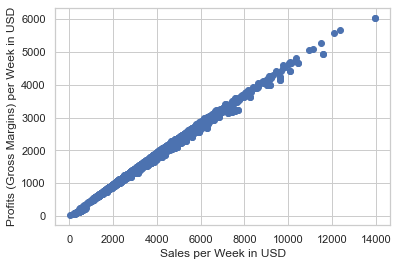

In [6]:
plt.scatter(data = data_merged, x= 'Sales', y = 'Gross_Margin')
plt.xlabel('Sales per Week in USD')
plt.ylabel('Profits (Gross Margins) per Week in USD')

In [7]:
corr_= data_merged.Sales.corr(data_merged.Gross_Margin).round(3)
print ('The correlation value between Sales and Gross Margin: ', corr_)

The correlation value between Sales and Gross Margin:  0.998


> Sales are strongly & postively correlated with Gross Margin. Its correlation value is 0.998, which is highly close to one. Since "Gross Margin" represents "Profit" which is the evaluation metric for business decision, I continue the analysis with "Gross Margin" variable, instead of "Sales".

### 2. Categorical  Control Variables: Region, State, City
### 2-1 Region
Does "region" impact on Sales? In other words. did the demographics around stores in the east region results in differing sales trend than in other regions? If yes, the assumption is the region does create differences in store performance. In this case, we should take into account the variable. Otherwise we do not need to group the stores into regions. 

Text(0.5, 1.0, 'Gross Margin Comparision ')

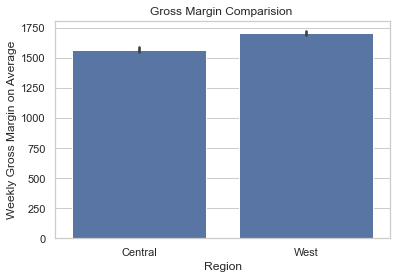

In [8]:
# Average gross margin between two regions. 
plt.figure(figsize=[6,4])
base_color = sns.color_palette()[0]
sns.barplot(data = data_merged, x = 'Region', y = 'Gross_Margin',color = base_color)
plt.ylabel('Weekly Gross Margin on Average')
plt.title('Gross Margin Comparision ')

In [9]:
from scipy import stats
region_test=data_merged.copy()
west= region_test.query('Region =="West"') 
central = region_test.query('Region != "West"') 

In [10]:
# T-test for "Average Month Sales"
stats.ttest_ind(west.Gross_Margin , central.Gross_Margin , equal_var = False)

Ttest_indResult(statistic=12.098867103647965, pvalue=2.096756707314455e-33)

In [11]:
# T-test for "Average Month Sales"
stats.ttest_ind(west.Sales , central.Sales , equal_var = False)

Ttest_indResult(statistic=11.606284451586799, pvalue=6.864356567474948e-31)

>- The T-tests results show that the mean difference of Average Month Sales is statistically significant, with the alpha level 0.05. This indicates that the region has an impact on sales. We should take into account the variable for AB Test.
>- Note that discrete variables can not be used to match treatments to controls directly. To accommodate discrete variables, treatment units need to be matched with the control units that share a discrete characteristics. In other words, matching treatments to controls for each region separately to ensure the best results.

### 2-2 States

In [12]:
# There are only two different states. 
stores_df.query('Group =="treatment"').State.unique()

array(['IL', 'CO'], dtype=object)

In [13]:
# Filter the datapoints either its State is IL or CO.
compare_state=data_merged.query('State =="IL" | State =="CO"') 
stores_state = stores_df.query('State =="IL" | State =="CO"') 

Text(0.5, 1.0, 'Average Profits Comparison between States')

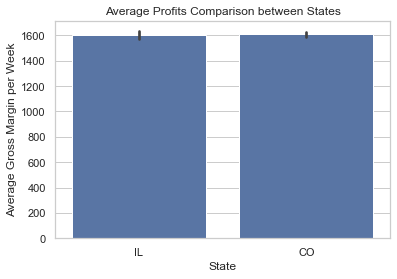

In [14]:
base_color = sns.color_palette()[0]
plt.figure(figsize=[6,4])
sns.barplot(data = compare_state, x = 'State', y = 'Gross_Margin',color = base_color)
plt.ylabel('Average Gross Margin per Week')
plt.title('Average Profits Comparison between States')

In [15]:
state_test=data_merged.copy()
IL= state_test.query('State =="IL"') 
CO= state_test.query('State =="CO"') 

In [16]:
# T-test for "Average Month Gross Margin"
stats.ttest_ind(IL.Gross_Margin , CO.Gross_Margin , equal_var = False)

Ttest_indResult(statistic=-0.2777643595263143, pvalue=0.7812129176855382)

In [17]:
# T-test for "Average Month Sales"
stats.ttest_ind(IL.Sales , CO.Sales , equal_var = False)

Ttest_indResult(statistic=-0.17907113178752485, pvalue=0.8578944322702904)

> The barplot shows that there is no significant differene on average profits between the two States. The following T-test supports the results that the mean differences of Gross Margin and Sales are **NOT** statistically significant, with the alpha level 0.05. This indicates that the categorical variable 'State' does not have an impact on Gross Margin and Sales . We do not need to group our stores based on its state.

### 2-3 City 

In [18]:
# Check which cities the dataset contains. 
stores_df.query('Group =="treatment"').City.unique()

array(['Barrington', 'Mount Prospect', 'Schaumburg', 'Oakbrook Terrace',
       'Orland Park', 'Aurora', 'Westminster', 'Denver', 'Boulder'],
      dtype=object)

In [19]:
compare_city=data_merged.query('City =="Barrington" | City =="Mount Prospect"| City == "Schaumburg" | City == "Oakbrook Terrace"| City == "Orland Park" | City =="Aurora" | City =="Westminster" | City == "Denver"| City =="Boulder"')
stores_city=stores_df.query('City =="Barrington" | City =="Mount Prospect"| City == "Schaumburg" | City == "Oakbrook Terrace"| City == "Orland Park" | City =="Aurora" | City =="Westminster" | City == "Denver"| City =="Boulder"')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Barrington'),
  Text(1, 0, 'Mount Prospect'),
  Text(2, 0, 'Schaumburg'),
  Text(3, 0, 'Oakbrook Terrace'),
  Text(4, 0, 'Orland Park'),
  Text(5, 0, 'Aurora'),
  Text(6, 0, 'Westminster'),
  Text(7, 0, 'Denver'),
  Text(8, 0, 'Boulder')])

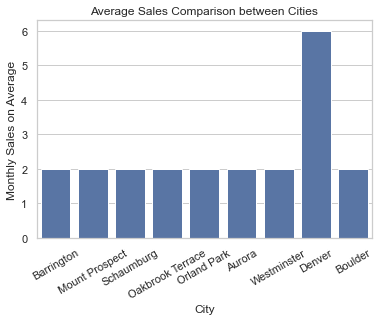

In [20]:
# Check how many stores are located in each city. 
plt.figure(figsize=[6,4])
sns.countplot(data = stores_city, x = 'City',color = base_color)
plt.ylabel('Monthly Sales on Average')
plt.title('Average Sales Comparison between Cities')
plt.xticks(rotation =30)

> Only in Denver, six stores are located. There is only one store in other cities.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Barrington'),
  Text(1, 0, 'Mount Prospect'),
  Text(2, 0, 'Schaumburg'),
  Text(3, 0, 'Oakbrook Terrace'),
  Text(4, 0, 'Orland Park'),
  Text(5, 0, 'Aurora'),
  Text(6, 0, 'Westminster'),
  Text(7, 0, 'Denver'),
  Text(8, 0, 'Boulder')])

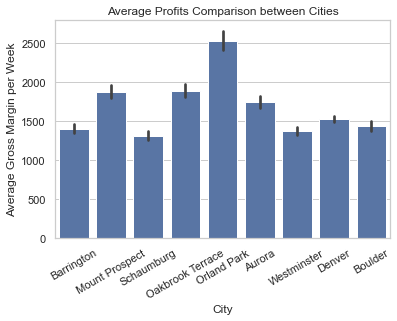

In [21]:
# Visualize the average profit per cities.
plt.figure(figsize=[6,4])
sns.barplot(data = compare_city, x = 'City', y = 'Gross_Margin',color = base_color)
plt.ylabel('Average Gross Margin per Week')
plt.title('Average Profits Comparison between Cities')
plt.xticks(rotation =30)

In [22]:
city_test=data_merged.copy()
Barrington= city_test.query('City =="Barrington"') 
Mount_Prospect= city_test.query(' City =="Mount Prospect"') 
Schaumburg = city_test.query('City == "Schaumburg"')
Oakbrook_Terrace = city_test.query('City == "Oakbrook Terrace"')
Orland_Park = city_test.query('City == "Orland Park"')
Aurora= city_test.query('City =="Aurora"')
Denver = city_test.query('City =="Denver"')
Boulder= city_test.query('City =="Boulder"')
Westminster= city_test.query('City =="Westminster"')

In [23]:
from scipy.stats import f_oneway
f_oneway(Barrington.Gross_Margin, Mount_Prospect.Gross_Margin, Schaumburg.Gross_Margin, Oakbrook_Terrace.Gross_Margin, Orland_Park.Gross_Margin, Aurora.Gross_Margin, Denver.Gross_Margin, Boulder.Gross_Margin, Westminster.Gross_Margin)

F_onewayResult(statistic=109.33650246768298, pvalue=9.566229859023813e-147)

> It seems that "Oakbrook Terrace" achieved the best performance in terms of gross margin. This fact is also supported by one-way analysis of variance (abbreviated one-way ANOVA) that at least one pair of stores is significantly different in terms of the average profits. ANOVA test is generally used to compare means of two or more samples (using the F distribution). The ANOVA tests the null hypothesis, which states that samples in all groups are drawn from populations with the same mean values. Remember that most cities have only one store. So it is not possible to find the stores that highly matched to the treatment stores. Thus, it is very unlikely to consider the variable "City" as a control variable. 

**Insights from Categorical Control Variables Analysis** <br> 
- Geographical variables
The gross margins of each store can be differed from store location. Among all the location information in the dataset, I will consider the 'Region' as a proxy of store location, only. We do not need to consider 'State' as a control variable, because it turns that the mean differences of Gross Margin between the 2 states are NOT statistically significant. In other words, 'State' does not have an impact on Gross Margin. Although 'City' is in the same situation with 'Region', it is far less extended category. By controlling 'Region', we can still have more options to find control units when we match treatment units with them. 
- Timezone related variables in dataset do not show linear relationships with the gross margin variables. Thus, they are not taken into account as the candidates of control variables.


### 3. Continuous Control Variables: Store Size, Average Monthly Sales

> To check the strength of correlations between all the continuous variables, I visualized a heatmap, first. From the heatmap, we can easily recognize the correlation through its color and annotation.

<AxesSubplot:>

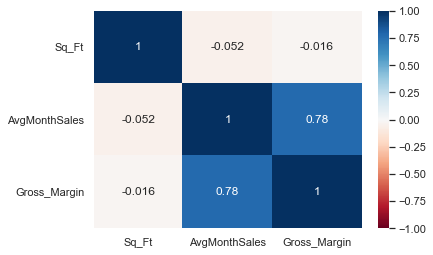

In [24]:
plt.figure(figsize=(6,4))
col = ['Sq_Ft', 'AvgMonthSales','Gross_Margin']
sns.heatmap(data_merged[col].corr(), annot = True,cmap="RdBu", center=0, vmin=-1, vmax=1)

Text(0.5, 1.0, 'Scatter Plot of Average Sales and Gross Margin')

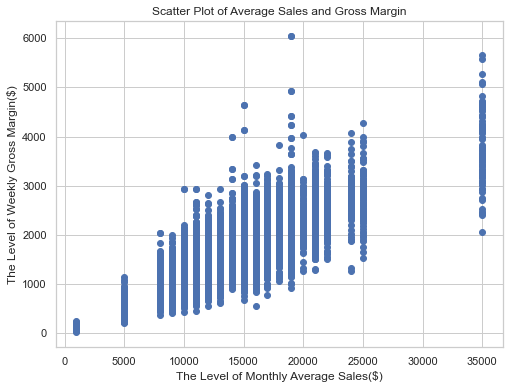

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(data = data_merged, x= 'AvgMonthSales', y = 'Gross_Margin')
plt.ylabel('The Level of Weekly Gross Margin($)')
plt.xlabel('The Level of Monthly Average Sales($)')
plt.title('Scatter Plot of Average Sales and Gross Margin')

- ‘AvgMonthSales’ is considered as a control variable, since it has a high correlation with ‘Gross Margin’, the performance metric in this analysis. As the heatmap plot and the correlation matrix show, the correlation between ‘AvgMonthSales’ and ‘Gross Margin per Week’ is high: 0.78. Thus, ‘AvgMonthSales’ should be controlled in the analysis.
- On the other hand, the size of store('Sq_Ft') has almost zero correlation with 'Gross Margin'. Its correlation with ‘Gross Margin per Week’is -0.016. This indicates that the size of store does not have an influence on the gross profit of each store. So, it does not need to be considered as a control variable.